## 2 agents - Continuous Action Space - Final Project - CS695
Author: Hoang-Dung Bui

Created date: 2023-11-25


## Installation

In [ ]:
# !pip uninstall tensorflow
# !pip install tensorflow-gpu
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 12.1 MB/s 


## Import

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # -1:cpu, 0:first gpu
import random
import pylab
import numpy as np
import copy
import math
import time
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch import nn
import torch.optim as optim
from threading import Thread, Lock
from shapely.geometry import LineString
from shapely.geometry import Point
# import tensorflow as tf
#tf.config.experimental_run_functions_eagerly(True) # used for debuging and development
# tf.compat.v1.disable_eager_execution() # usually using this for fastest performance
# from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Concatenate
# from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad, Adadelta
# from tensorflow.keras import backend as K
# import tensorflow_probability as tfp

# from tensorboardX import SummaryWriter


# from multiprocessing import Process, Pipe
# from tensorflow.keras import datasets, layers, models

In [2]:
# tf.compat.v1.disable_eager_execution() # usually using this for fastest performance

## Continuous Environments - 2Agents

### Building the environments

In [23]:
class create_environment:
  def __init__(self, obs_num=4, agent_num=2, map_width=7.0, map_height=10.0, agent_size=0.5):
    self.map_width = map_width
    self.map_height = map_height
    self.episode_length = 2*int(map_height+map_width)
    self.agent_num = agent_num
    self.agent_size = agent_size
    self.obstacles = []
    self.obs_num = obs_num
    self.ep_step = 0
    self.goals_reward = 20.0
    self.collision_reward = -2.0
    self.move_reward = -0.2
    self.goal_rad = 0.4
    self.initial_starts =  [[4.,2.65], [5.8,4.1]]
    self.initial_goals =  [[6.6, 4.1], [3.5, 4.1]]
    # self.start_dis_thres = 40.0
    self.reachGoalDist = 0.39
    self.a2aDisThres = self.agent_size+0.2
    # self.pf_factor = 450.0
    # self.pf_dmax = 50.0
    self.moveDisThres = 0.75
    self.create_obstacles()
    self.agents = np.zeros((self.agent_num, 2))
    self.goals = np.zeros((self.agent_num, 2))
    self.set_initial_starts()
    self.set_initial_goals()
    self.count_frames = 0
    self.view_size = 600
    self.resolution = 100
    self.mutex  = Lock()

  def create_obstacles(self):
    # create and draw obstacles
    self.obstacles = np.zeros((1000,700)).astype(int)
    self.obstacles[0,:] = 1
    self.obstacles[999,:] = 1
    self.obstacles[:,0] = 1
    self.obstacles[:,699] = 1
    self.obstacles[200:799,1:200] = 1
    self.obstacles[200:799,499:699] = 1
    self.obstacles[200:349,200:350] = 1
    self.obstacles[650:799,200:350] = 1

  def set_start(self, robotId, pos):
    self.agents[robotId] = pos

  def set_goal(self, robotId, pos):
    self.goals[robotId] = pos

  def get_start(self, robotId):
    return self.agents[robotId]

  def get_goal(self, robotId):
    return self.goals[robotId]

  def two_points_distance(self, point1, point2):
    d = np.sqrt( (float(point1[0] - point2[0]))**2 + float((point1[1] - point2[1]))**2)
    # print(f"d = {d}")
    return d

  def set_initial_starts(self):
    for i in range(self.agent_num):
        self.set_start(i, self.initial_starts[i])
    # pos = [9.,2.65]
    # self.set_start(1, pos)

  def set_initial_goals(self):
    for i in range(self.agent_num):
        self.set_goal(i, self.initial_goals[i])

  def getDistOrient(self, robotId):
    distOrien = np.zeros(3)
    distOrien[0] = self.goals[robotId, 0] - self.agents[robotId, 0]
    distOrien[1] = self.goals[robotId, 1] - self.agents[robotId, 1]
    distOrien[2] = np.sqrt(distOrien[0]**2 + distOrien[1]**2)
    distOrien[0] = distOrien[0]/distOrien[2]
    distOrien[1] = distOrien[1]/distOrien[2]
    return distOrien

  def min_agents_distances(self):  # for potential field
    dis_array = np.zeros((self.agent_num, self.agent_num))
    min_dis = np.zeros(self.agent_num)
    for i in range(self.agent_num):
      for j in range(i+1, self.agent_num):
        dis = self.two_points_distance(self.agents[i,:], self.agents[j,:])
        dis_array[i,j] = dis
        dis_array[j,i] = dis
    for i in range(self.agent_num):
      min_dis[i] = np.partition(dis_array[i,:], 1)[1] # order the second smallest element at position 1
    return min_dis

  # check wall collision
  def wall_collision(self, agentId, action, jump_out_pen):
    new_h = self.agents[agentId,0] + action[0]
    new_w = self.agents[agentId,1] + action[1]
    reward = 0.0
    done = False

    # collide to the walls
    if new_h < 0.5*self.agent_size:
      reward = jump_out_pen
      done = True
    elif new_h > self.map_height-0.5*self.agent_size:
      reward = jump_out_pen
      done = True
    elif new_w < 0.5*self.agent_size:
      reward = jump_out_pen
      done = True
    elif new_w > self.map_width-0.5*self.agent_size:
      reward = jump_out_pen
      done = True
    return reward, done

  # check head to head collision
  def h2h_collision(self, robotId, action, collide_pen):
    reward = 0.0
    done = False
    # check the target positions
    new_pos_h = float(self.agents[robotId, 0] + action[0])
    new_pos_w = float(self.agents[robotId, 1] + action[1])
    # print(f"new position: {new_pos_h} {new_pos_w}")

    for i in range(self.agent_num):
      if not (robotId == i):
        dist = self.two_points_distance(self.agents[i], np.array([new_pos_h, new_pos_w]))
        if dist < self.a2aDisThres:
          # print(f"distance between two robots: {dist}")
          reward = collide_pen
          done = True
          return reward, done
    # if the agent moves over a threshold, check the middle point
    if np.sqrt(action[0]**2 + action[1]**2) > self.moveDisThres:
      new_pos_h = float(self.agents[robotId, 0] + float(0.5*action[0]))
      new_pos_w = float(self.agents[robotId, 1] + float(0.5*action[1]))
      for i1 in range(self.agent_num):
        if not (robotId == i1):
          dist1 = self.two_points_distance(self.agents[i1], np.array([new_pos_h, new_pos_w]))
          if dist1 < self.a2aDisThres:
            reward = collide_pen
            done = True
            return reward, done
    return reward, done

  # check obstacles collision
  def obs_collision(self, robotId, action, collide_pen):
    travelDist = np.sqrt(action[0]**2 + action[1]**2)
    n = int(np.floor(travelDist/self.agent_size))
    reward = 0.0
    done = False
    for i in range(n):
      ratio = float(i+1)*self.agent_size/travelDist
      pos_h = self.agents[robotId, 0]+action[0]*ratio
      pos_w = self.agents[robotId, 1]+action[1]*ratio
      if self.obs_check_operator([pos_h, pos_w]):
        done = True
        reward = collide_pen
    pos_h1 = self.agents[robotId, 0]+action[0]
    pos_w1 = self.agents[robotId, 1]+action[1]
    # print("the second last position")
    if self.obs_check_operator([pos_h1, pos_w1]):
        done = True
        reward = collide_pen
    return reward, done

  # obstacles collision check operator
  def obs_check_operator(self, pos):
    h1 = int(np.floor((pos[0]-0.5*self.agent_size)*float(self.resolution)))
    h2 = int(np.ceil((pos[0]+0.5*self.agent_size)*float(self.resolution)))
    w1 = int(np.floor((pos[1]-0.5*self.agent_size)*float(self.resolution)))
    w2 = int(np.ceil((pos[1]+0.5*self.agent_size)*float(self.resolution)))
    # print(f"the area: {h1} {h2} {w1} {w2}")
    if np.sum(self.obstacles[h1:h2,w1:w2]) > 0:
      return True
    else:
      return False

  def potential_field_reward(self):
    distances = self.min_agents_distances()
    # print(distances)
    pf_reward = np.zeros_like(distances)
    for i in range(len(distances)):
      if distances[i] >= self.pf_dmax:
        pf_reward[i] = 0.0
      else:
        nuy = self.pf_factor*self.goals_reward
        pf_reward[i] = -0.5*nuy*np.square(1.0/distances[i] - 1.0/self.pf_dmax)
    return pf_reward

  def getObsMap(self, robotId):
    # view_size = self.view_size
    pov_obs = np.ones((self.view_size,self.view_size))
    start_pixel_h = round(self.agents[robotId, 0]*100.0)-int(self.view_size/2)
    start_pixel_w = round(self.agents[robotId, 1]*100.0)-int(self.view_size/2)
    end_pixel_h = round(self.agents[robotId, 0]*100.0)+int(self.view_size/2)
    end_pixel_w = round(self.agents[robotId, 1]*100.0)+int(self.view_size/2)
    pov_obs_start_h = 0
    pov_obs_start_w = 0
    pov_obs_end_h = self.view_size
    pov_obs_end_w = self.view_size
    if (round(self.agents[robotId, 0]*100.0)-int(self.view_size/2) <0):
      start_pixel_h = 0
      pov_obs_start_h = int(self.view_size/2)-round(self.agents[robotId, 0]*100.0)
    if (round(self.agents[robotId, 1]*100.0)-int(self.view_size/2) <0):
      start_pixel_w = 0
      pov_obs_start_w = int(self.view_size/2)-round(self.agents[robotId, 1]*100.0)
    if (round(self.agents[robotId, 0]*100.0)+int(self.view_size/2) > self.obstacles.shape[0]):
      end_pixel_h = self.obstacles.shape[0]
      pov_obs_end_h = self.obstacles.shape[0]-round(self.agents[robotId, 0]*100.0)+int(self.view_size/2)
    if (round(self.agents[robotId, 1]*100.0)+int(self.view_size/2) > self.obstacles.shape[1]):
      end_pixel_w = self.obstacles.shape[1]
      pov_obs_end_w = self.obstacles.shape[1]-round(self.agents[robotId, 1]*100.0)+int(self.view_size/2)

    pov_obs[pov_obs_start_h:pov_obs_end_h,pov_obs_start_w:pov_obs_end_w] = self.obstacles[start_pixel_h:end_pixel_h, start_pixel_w:end_pixel_w]
    # shrinken
    pov_obs_sh = np.zeros((100,100))
    for i in range(100):
      for j in range(100):
        if np.sum(pov_obs[6*i:6*i+6,6*j:6*j+6]) > 1:
          pov_obs_sh[i,j] = 1
    return pov_obs_sh

  def getAgentMap(self, robotId):
    pov_agent = np.zeros((self.view_size,self.view_size))
    for i in range(self.agent_num):
      if (i == robotId):
        pov_agent[int(self.view_size/2)-int(self.agent_size*100/2):int(self.view_size/2)+int(self.agent_size*100/2),
                  int(self.view_size/2)-int(self.agent_size*100/2):int(self.view_size/2)+int(self.agent_size*100/2)] = 1
      else:
        rel_h = round(100*(self.agents[i,0] - self.agents[robotId,0]))
        rel_w = round(100*(self.agents[i,1] - self.agents[robotId,1]))
        if (np.abs(rel_h) <= int(self.view_size/2)-int(self.agent_size/2)) and \
          (np.abs(rel_w) <= int(self.view_size/2)-int(self.agent_size/2)):
          pov_agent[rel_h+int(self.view_size/2)-int(self.agent_size*100/2):rel_h+int(self.view_size/2)+int(self.agent_size*100/2),
                    rel_w+int(self.view_size/2)-int(self.agent_size*100/2):rel_w+int(self.view_size/2)+int(self.agent_size*100/2)] = 1
    # shrinken
    pov_agent_sh = np.zeros((100,100))
    for i in range(100):
      for j in range(100):
        if np.sum(pov_agent[6*i:6*i+6,6*j:6*j+6]) > 0:
          pov_agent_sh[i,j] = 1
    return pov_agent_sh

  def getGoalMap(self, robotId):
    pov_goal = np.zeros((self.view_size, self.view_size))
    rel_h = round(100*(self.goals[robotId,0] - self.agents[robotId,0]))
    rel_w = round(100*(self.goals[robotId,1] - self.agents[robotId,1]))
    if (np.abs(rel_h) <= int(self.view_size/2)) and (np.abs(rel_w) <= int(self.view_size/2)):
      row = np.arange(0, self.view_size)
      column = np.arange(0, self.view_size)
      # for the goals
      mask = (row[np.newaxis,:]-rel_w-int(self.view_size/2))**2 + (column[:,np.newaxis]-rel_h-int(self.view_size/2))**2 < \
              int((self.agent_size*100))**2
      pov_goal[mask] = 1.0
    # shrinken
    pov_goal_sh = np.zeros((100,100))
    for i in range(100):
      for j in range(100):
        if np.sum(pov_goal[6*i:6*i+6,6*j:6*j+6]) > 10:
          pov_goal_sh[i,j] = 1
    return pov_goal_sh
  def getNeiGoalMap(self, robotId):
    pov_goal = np.zeros((self.view_size, self.view_size))
    for i in range(self.agent_num):
      if (i==robotId):
        continue
      rel_h = round(100*(self.goals[i,0] - self.agents[robotId,0]))
      rel_w = round(100*(self.goals[i,1] - self.agents[robotId,1]))

      if (np.abs(rel_h) <= int(self.view_size/2)) and (np.abs(rel_w) <= int(self.view_size/2)):
        row = np.arange(0, self.view_size)
        column = np.arange(0, self.view_size)
        # for the goals
        mask = (row[np.newaxis,:]-rel_w-int(self.view_size/2))**2 + (column[:,np.newaxis]-rel_h-int(self.view_size/2))**2 < \
                int((self.agent_size*100))**2
        pov_goal[mask] = 1.0
    # shrinken
    pov_goal_sh = np.zeros((100,100))
    for i in range(100):
      for j in range(100):
        if np.sum(pov_goal[6*i:6*i+6,6*j:6*j+6]) > 10:
          pov_goal_sh[i,j] = 1
    return pov_goal_sh

  def convertArray2Image(self, pov_array):
    img = Image.new('1', (100, 100), color=1)
    pixels = img.load()
    for i in range(img.size[0]):
      for j in range(img.size[1]):
        if pov_array[j,i] == 1:
          pixels[i, j] = 0
    return img

  # move to the next state
  def step(self, robotId, action):
    reward = 0
    info = 0
    done = False
    display = True
    self.ep_step += 1
    self.mutex.acquire()
    if not done: # check collision with walls
      r1, d1 = self.wall_collision(robotId, action, self.collision_reward)
      reward += r1
      done = done or d1
      # if d1:
      #   print(f"collision at wall: {reward}")
    if not done: # check collision with other robots
      r2, d2 = self.h2h_collision(robotId, action, self.collision_reward)
      reward += r2
      done = done or d2
      # if d2:
      #   print(f"colliding with other robots: {reward}")
    if not done: # check collision with obstacles
      r3, d3 = self.obs_collision(robotId, action, self.collision_reward)
      reward += r3
      done = done or d3
      # if d3:
      #   print(f"colliding with obstacles: {reward}")

    if not done:
      self.agents[robotId,0] += action[0]
      self.agents[robotId,1] += action[1]

    disToGoal = np.zeros(self.agent_num)
    for i in range(self.agent_num):
      disToGoal[i] = self.two_points_distance(self.agents[i], self.goals[i])

    if not done:
      if np.all(disToGoal < self.reachGoalDist):
        reward = self.goals_reward
        print("--------- Alls reach the goals ------------------------")
        done = True
      elif disToGoal[robotId] < self.reachGoalDist:
        reward = 0.0
        print(f"robot {robotId} reach its goal")
        info = 1
      else:
        reward = self.move_reward

    if self.ep_step == self.episode_length:
      done = True
      # info = 1

    # get the orientation and distance
    dist_orient = self.getDistOrient(robotId)
    # returning the maps
    imgObs = self.getObsMap(robotId)
    if display:
      img = self.convertArray2Image(imgObs)
      img.save('obstacle'+str(self.count_frames)+'.png')

    # create agent channel
    imgAgent = self.getAgentMap(robotId)
    if display:
      img = self.convertArray2Image(imgAgent)
      img.save('agent'+str(self.count_frames)+'.png')

    # create goal channel
    imgGoal = self.getGoalMap(robotId)
    if display:
      img = self.convertArray2Image(imgGoal)
      img.save('goal'+ str(self.count_frames)+'.png')

    # creat neighbor goal channel
    imgNeiGoal = self.getNeiGoalMap(robotId)
    if display:
      img = self.convertArray2Image(imgNeiGoal)
      img.save('goalNei'+ str(self.count_frames)+'.png')

    self.count_frames += 1
    if (self.count_frames >= 100000):
      self.count_frames = 0
    # plt.imshow(imgGoal)
    self.mutex.release()
    return np.array((imgObs, imgAgent, imgGoal, imgNeiGoal)).astype(np.float32), \
            dist_orient.astype(np.float32), reward, done, info


  # this function reset as the agent complete the training for one pair start - end points
  def reset(self, robotId):
    # self.agents = self.get_agents_start()
    display = True
    self.mutex.acquire()
    pos = [[1.0,4.8], [9.,2.65]]
    self.set_start(robotId, pos[robotId])
    # self.goals = self.get_agents_goals()

    # get the orientation and distance
    dist_orient = self.getDistOrient(robotId)
    # returning the maps
    imgObs = self.getObsMap(robotId)
    if display:
      imgObs.save('obstacle'+str(self.count_frames)+'.png')

    # create agent channel
    imgAgent = self.getAgentMap(robotId)
    if display:
      imgAgent.save('agent'+str(self.count_frames)+'.png')

    # create goal channel
    imgGoal = self.getGoalMap(robotId)
    if display:
      imgGoal.save('goal'+ str(self.count_frames)+'.png')

    # creat neighbor goal channel
    imgNeiGoal = self.getNeiGoalMap(robotId)
    if display:
      imgNeiGoal.save('goalNei'+ str(self.count_frames)+'.png')

    # self.count_frames += 1
    # if (self.count_frames >= 100000):
    #   self.count_frames = 0
    # plt.imshow(imgGoal)
    self.ep_step = 0
    self.mutex.release()
    return np.array((imgObs, imgAgent, imgGoal, imgNeiGoal)).astype(np.float32), \
        dist_orient.astype(np.float32)

  def render(self):
    # img = Image.new('1', (1000, 1500), color=1)
    img = Image.new('RGB', (700, 1000), color=(255,255,255))
    pixels = img.load()
    map_robots = np.copy(self.obstacles).astype(float)

    colorDisplay = [255,150,180,210]
    row = np.arange(0,700)
    column = np.arange(0,1000)
    for i in range(self.agent_num):
      # for the start pose
      map_robots[round(self.agents[i,0]*100.0)-25:round(self.agents[i,0]*100.0)+26,
              round(self.agents[i,1]*100.0)-25:round(self.agents[i,1]*100.0)+26] = 0.2*(i+1)
      # for the goals
      mask = (row[np.newaxis,:]-self.goals[i,1]*100.0)**2 + (column[:,np.newaxis]-self.goals[i,0]*100.0)**2 < 30.0**2
      map_robots[mask] = 0.2*(i+1)


    for i in range(img.size[0]):
      for j in range(img.size[1]):
        if map_robots[j,i] == 1:
          pixels[i, j] = (0,0,0)
        elif map_robots[j,i] == 0.2:
          pixels[i, j] = (colorDisplay[0],0,0)
        elif map_robots[j,i] == 0.4:
          pixels[i, j] = (0,colorDisplay[0],0)

    plt.imshow(img)
    img.save('image.png')

### Testing the environments - simple scenarios

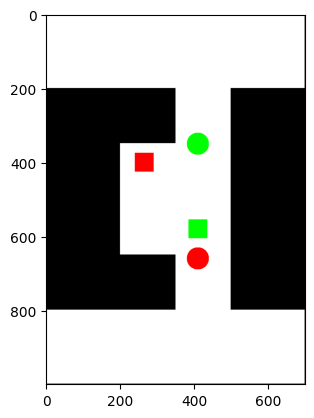

In [24]:
env = create_environment(4, agent_num=2, map_width=7.0, map_height=10.0, agent_size=0.5)
# env.render()
action = [0.0, 0.0]
env.step(0, action)
# print(r)
env.render()

## Environments Wrapping

In [ ]:
class Environment(Process):
    def __init__(self, env_idx, child_conn, env_name, state_size, action_size,
                    obs_num, agent_num, map_dims):
        super(Environment, self).__init__()
        self.env = create_environment(obs_num, agent_num, map_dims)
        self.env_idx = env_idx
        self.child_conn = child_conn
        self.state_size = state_size
        self.action_size = action_size

    def run(self):
        super(Environment, self).run()
        state = self.env.reset()
        state = np.reshape(state, [1, self.state_size])
        self.child_conn.send(state)
        while True:
            action = self.child_conn.recv()

            state1, reward, done, info = self.env.step(action)
            state1 = np.reshape(state1, [1, self.state_size])

            if done:
                state2 = self.env.reset()
                state2 = np.reshape(state, [1, self.state_size])
            else:
                state2 = state1.copy()

            self.child_conn.send([state1, state2, reward, done, info])

## Networks

### Actor Model

In [ ]:
class ActorModel(torch.nn.Module):
    def __init__(self, input_shape, action_space, lr):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=4,out_channels=32,kernel_size=5, stride=1, padding='valid')
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=128,kernel_size=5,stride=1,padding='valid')
        self.conv3 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding='same')
        self.conv4 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding='same')

        self.relu = nn.ReLU(inplace=True)
        self.bn1  = nn.BatchNorm2d(num_features=32)
        self.bn2   = nn.BatchNorm2d(num_features=128)
        self.bn3   = nn.BatchNorm2d(num_features=256)
        self.bn3   = nn.BatchNorm2d(num_features=256)

        self.mp1   = nn.MaxPool2d(kernel_size=4,stride=4)
        self.mp2   = nn.MaxPool2d(kernel_size=5,stride=5)
        self.do   = nn.Dropout(p=0.2)
        self.l1   =  nn.Linear(3,40)
        self.l2   =  nn.Linear(4136,512)
        self.l3   =  nn.Linear(512,action_space)
        self.l4   =  nn.Linear(512,action_space)
        self.tan  =  nn.Tanh()
        self.sig  =  nn.Sigmoid()
        self.flat =  nn.Flatten()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, images, pose):
        img = self.conv_layers1(images)
        # print(img.shape)
        img = self.conv_layers2(img)
        img = self.conv_layers3(img)
        img = self.conv_layers4(img)
        N ,_,_,_ = img.size()
        img = img.view(N,-1)
        # img = self.flat(img)
        # print(img.shape)
        pos = self.l1(pose)
        # print(pos.shape)
        com = torch.cat((img, pos), 1)

        com = self.l2(com)
        com = self.relu(com)
        com = self.do(com)
        com = self.relu(com)
        means = self.l3(com)
        means = self.tan(means)
        stds = self.l4(com)
        stds = self.sig(stds)
        return means, stds

    def conv_layers1(self,x):
        x = self.conv1(x)
        # print(x.shape)
        x = self.relu(x)
        # print(x.shape)
        x = self.bn1(x)
        # print(x.shape)
        x = self.mp1(x)
        # print(x.shape)
        return x

    def conv_layers2(self,x):
        x = self.conv2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.mp2(x)
        return x

    def conv_layers3(self,x):
        x = self.conv3(x)
        x = self.relu(x)
        return x

    def conv_layers4(self,x):
        x = self.conv4(x)
        x = self.relu(x)
        return x

    def sample_action(self, state_img, state_pos):
        means, stds = self.forward(state_img, state_pos)
        # if torch.abs(action_means) <1e-6:
        #     action_means = torch.tensor(0, dtype=torch.float)
        # if torch.abs(action_stddevs) < 1e-6:
        #     action_stddevs = torch.tensor(1e-6, dtype=torch.float)
        dist_h = torch.distributions.Normal(means[:,0], stds[:,0])
        dist_w = torch.distributions.Normal(means[:,1], stds[:,1])
        # if epsilon > 0.0:
        #     raise ValueError("No 'epsilon greedy' for this policy.")
        action_w = dist_w.sample()
        action_h = dist_h.sample()
        # print(action_h)
        # print(type(action_h.numpy()))
        return action_h.numpy(), action_w.numpy()

    def get_action_log_prob(self, state_img, state_pos, action):
        action_means, action_stddevs = self.forward(state_img, state_pos)
        # if torch.abs(action_means) <1e-6:
        #     action_means = torch.tensor(0, dtype=torch.float)
        # if torch.abs(action_stddevs) < 1e-6:
        #     action_stddevs = torch.tensor(1e-6, dtype=torch.float)
        dist_h = torch.distributions.Normal(action_means[:,0], action_stddevs[:,0])
        dist_w = torch.distributions.Normal(action_means[:,1], action_stddevs[:,1])
        # logprob_h = dist_h.log_prob(torch.tensor(action[0], dtype=torch.float))
        # logprob_w = dist_w.log_prob(torch.tensor(action[1], dtype=torch.float))
        logprob_h = dist_h.log_prob(action[:,0])
        logprob_w = dist_w.log_prob(action[:,1])
        # print(logprob_h)
        # print(type(logprob_h))
        return logprob_h.detach().numpy(), logprob_w.detach().numpy()


### Critic Model

In [ ]:
class CriticModel(torch.nn.Module):
    def __init__(self, input_shape, pose_shape, lr):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=4,out_channels=32,kernel_size=5, stride=1, padding='valid')
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=128,kernel_size=5,stride=1,padding='valid')
        self.conv3 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding='same')
        self.conv4 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding='same')

        self.relu = nn.ReLU(inplace=True)
        self.bn1  = nn.BatchNorm2d(num_features=32)
        self.bn2   = nn.BatchNorm2d(num_features=128)
        self.bn3   = nn.BatchNorm2d(num_features=256)
        self.bn3   = nn.BatchNorm2d(num_features=256)

        self.mp1  =  nn.MaxPool2d(kernel_size=4,stride=4)
        self.mp2  =  nn.MaxPool2d(kernel_size=5,stride=5)
        self.do   =  nn.Dropout(p=0.2)
        self.l1   =  nn.Linear(pose_shape,40)
        self.l2   =  nn.Linear(4136,512)
        self.l3   =  nn.Linear(512,512)
        self.l4   =  nn.Linear(512,1)
        # self.tan  =  nn.Tanh()
        # self.sig  =  nn.Sigmoid()
        self.flat =  nn.Flatten()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, images, pose):
        img = self.conv_layers1(images)
        img = self.conv_layers2(img)
        img = self.conv_layers3(img)
        img = self.conv_layers4(img)
        N ,_,_,_ = img.size()
        img = img.view(N,-1)
        pos = self.l1(pose)
        com = torch.cat((img, pos), 1)

        com = self.l2(com)
        com = self.do(com)
        com = self.relu(com)
        com = self.l4(com)
        com = self.do(com)
        com = self.relu(com)
        values = self.l3(com)
        return values

    def conv_layers1(self,x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.mp1(x)
        return x

    def conv_layers2(self,x):
        x = self.conv2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.mp2(x)
        return x

    def conv_layers3(self,x):
        x = self.conv3(x)
        x = self.relu(x)
        return x

    def conv_layers4(self,x):
        x = self.conv4(x)
        x = self.relu(x)
        return x

### Testing the models

In [ ]:
actor = ActorModel(input_shape=(4, 100,100), action_space = 2, lr=0.00001)
critic = CriticModel(input_shape=(4,100,100), pose_shape=3, lr=0.00001)


In [ ]:
pose = np.array((0.8, 0.6, 1)).astype(np.float32)
image1 = np.ones((100,100)).astype(np.float32)
image2 = np.ones((100,100)).astype(np.float32)
image3 = np.ones((100,100)).astype(np.float32)
image4 = np.ones((100,100)).astype(np.float32)
input_array = np.array((image1, image2, image3, image4))
input_data = torch.from_numpy(input_array)
pose_con = torch.from_numpy(pose)

results = actor.forward(input_data.unsqueeze(0), pose_con.unsqueeze(0))
print(results)
action_h, action_w = actor.sample_action(input_data.unsqueeze(0), pose_con.unsqueeze(0))
# print(action_h)
# print(action_w)
action_ten = torch.from_numpy(np.array([action_h, action_w]))
logprob_h, logprob_w = actor.get_action_log_prob(input_data.unsqueeze(0), pose_con.unsqueeze(0), action_ten.unsqueeze(0))
# logprob_h, logprob_w = actor.get_action_log_prob(input_data.unsqueeze(0), pose_con.unsqueeze(0), [action_h, action_w])
# print(logprob_h)
# print(logprob_w)
# V= critic.forward(input_data.unsqueeze(0), pose_con.unsqueeze(0))
# print(V)

(tensor([[0.0322, 0.0187]], grad_fn=<TanhBackward0>), tensor([[0.4875, 0.5050]], grad_fn=<SigmoidBackward0>))
tensor([0.1700])
<class 'numpy.ndarray'>


## Test the environment - a rollout and rendering

In [ ]:
epochs = 0
score_history = []
agent_num = 5
env = create_environment(obs_num=4, agent_num=2, map_width=7.0, map_height=10.0, agent_size=0.5)

def rollout(env, policy):
  score = 0.0
  # env.goal_thres_dis = 20.0
  # env.goals_away_dis = 30.0
  image1, pose1 = env.reset(0)
  image2, pose2 = env.reset(1)
  done = False
  n_step
  while (not done) and (n_steps < 200):
    act_h, act_w = policy.sample_action(image, pose)
    image, pose, reward, done, info = env.step()


  success = 0.0
  for episode in range(1, epochs+1):
    # global_step += 1
    local_step = 0
    done = False
    score = 0.0

    while not done:
      actions = np.zeros(agent_num*2).astype(int)
      for i in range(agent_num*2):
        actions[i] = random.randint(-9,9)
        # actions[i,1] = random.randint(-9,9)

      next_obser, reward, done, _ = env.step(actions)
      score += reward
      local_step += 1
      obser = next_obser.copy()

      # Finish trajectory if reached to a terminal state
      dis_to_goal = env.distances_to_goals()
      if done:
        print("The score for episode " +str(episode)+": "+str(score))
        if np.all(dis_to_goal <= env.reach_goal_thres):
          success += 1.0
        print("-----------------------------------------------")
        print("Episode " + str(episode) + " success-rate: " + str(round(success/episode,5)))
        print("The episode length: ", local_step)
        obser = env.reset()
        local_step = 0
test_random_actions()

## Buffer

In [ ]:
class PPOMemory:
    def __init__(self, batch_size):
        self.images = []
        self.orien = []
        self.next_images = []
        self.next_orien = []
        self.logprobs = []
        # self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size


    def generate_batches(self):
        n_states = len(self.images)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.images),\
                np.array(self.orien),\
                np.array(self.next_images), \
                np.array(self.next_orien),\
                np.array(self.actions),\
                np.array(self.logprobs),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches

    def store_memory(self, image, orien, next_image, next_orien, \
                          action, logprob, reward, done):
        self.images.append(image)
        self.orien.append(orien)
        self.next_images.append(next_image)
        self.next_orien.append(next_orien)
        self.actions.append(action)
        self.logprobs.append(logprob)
        # self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.images = []
        self.orien = []
        self.next_images = []
        self.next_orien = []
        self.logprobs = []
        self.actions = []
        self.rewards = []
        self.dones = []


In [ ]:
# array_Test = np.zeros((2,2,3)).astype(int)
# print(array_Test)
# array_Test1 = np.array((4,6)).astype(int)
# print(array_Test1)
n = 4
print(n)
n += 1
print(n)

4
5


## RL algorithms

In [ ]:
# PPO Main Optimization Algorithm
class PPO_Agent:
  def __init__(self, n_actions, input_dims, pose_shape, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
          policy_clip=0.2, batch_size=64, n_epochs=10, n_games=500, n_agents=2):
    self.gamma = gamma
    self.policy_clip = policy_clip
    self.n_epochs = n_epochs
    self.gae_lambda = gae_lambda
    self.n_games = n_games
    self.n_agents = n_agents
    self.N = int(batch_size*n_epochs)
    # print(self.N)
    self.actor = ActorModel(input_dims, n_actions, lr=alpha)
    self.critic = CriticModel(input_dims, pose_shape,lr = alpha)
    self.memory = [PPOMemory(batch_size), PPOMemory(batch_size)]

  def store(self, robotId, image, orien, next_image, next_orien, action, logprob, reward, done):
    self.memory[robotId].store_memory(image, orien, next_image, next_orien, action, logprob, reward, done)

  def get_gaes(self, rewards, dones, values, next_values, normalize=True):
    deltas = [r + self.gamma * (1 - d) * nv - v for r, d, nv, v in zip(rewards, dones, next_values, values)]
    deltas = np.stack(deltas)
    gaes = copy.deepcopy(deltas)
    for t in reversed(range(len(deltas) - 1)):
        gaes[t] = gaes[t] + (1 - dones[t]) * self.gamma*self.gae_lambda * gaes[t + 1]
    returns = gaes + values
    if normalize:
        gaes = (gaes - gaes.mean()) / (gaes.std() + 1e-8)
    advantages = gaes.astype(np.float32)
    returns = returns.astype(np.float32)
    return np.vstack(advantages), np.vstack(returns)

  def learn(self, robotId):
    for _ in range(self.n_epochs):
      images_arr, orien_Arr, next_images_arr, next_orien_Arr, actions_arr, old_logprobs_arr, \
            rewards_arr, dones_arr, batches = self.memory[robotId].generate_batches()

      images_arr = torch.tensor(images_arr, dtype=torch.float).to(self.actor.device)
      orien_Arr = torch.tensor(orien_Arr, dtype=torch.float).to(self.actor.device)

      next_images_arr = torch.tensor(next_images_arr, dtype=torch.float).to(self.actor.device)
      next_orien_Arr = torch.tensor(next_orien_Arr, dtype=torch.float).to(self.actor.device)

      old_logprobs_arr = torch.tensor(old_logprobs_arr).to(self.actor.device)
      actions = torch.tensor(actions_arr).to(self.actor.device)

      values = self.critic.forward(images_arr, orien_Arr)
      next_values = self.critic.forward(next_images_arr, next_orien_Arr)

      advantages, returns = self.get_gaes(rewards_arr, dones_arr, values.detach().numpy(), \
                                          next_values.detach().numpy())

      advantages = torch.tensor(advantages).to(self.actor.device)
      returns = torch.tensor(returns).to(self.actor.device)

      for batch in batches:
          images_batch = images_arr[batch]
          orien_batch = orien_Arr[batch]
          actions_batch = actions[batch]

          new_logprobs_h, new_logprobs_w = self.actor.get_action_log_prob(images_batch, orien_batch, actions_batch)

          new_logprobs_h = torch.tensor(new_logprobs_h).to(self.actor.device)
          new_logprobs_w = torch.tensor(new_logprobs_w).to(self.actor.device)

          prob_ratio1 = new_logprobs_h.exp() / old_logprobs_arr[:,0].exp()
          prob_ratio2 = new_logprobs_w.exp() / old_logprobs_arr[:,1].exp()
          #prob_ratio = (new_probs - old_probs).exp()
          weighted_probs1 = advantages[batch] * prob_ratio1
          weighted_probs2 = advantages[batch] * prob_ratio2

          weighted_clipped_probs1 = torch.clamp(prob_ratio1, 1-self.policy_clip,
                  1+self.policy_clip)*advantages[batch]
          weighted_clipped_probs2 = torch.clamp(prob_ratio2, 1-self.policy_clip,
                  1+self.policy_clip)*advantages[batch]


          actor_loss = -torch.min(weighted_probs1, weighted_clipped_probs1).mean() -\
                       torch.min(weighted_probs2, weighted_clipped_probs2).mean()


          critic_values = self.critic.forward(images_batch, orien_batch)
          critic_values = torch.squeeze(critic_values)

          returns_b = returns[batch]
          critic_loss = (returns_b-critic_values)**2
          critic_loss = critic_loss.mean()

          total_loss = actor_loss + 0.5*critic_loss
          self.actor.optimizer.zero_grad()
          self.critic.optimizer.zero_grad()
          total_loss.backward()
          self.actor.optimizer.step()
          self.critic.optimizer.step()

    self.memory[robotId].clear_memory()


  def run_batch(self, env):
    # Initialization - Environment and PPO parameters
    scores =        0
    n_steps = np.zeros(2).astype(int)

    for r in range(self.n_games):
      # Instantiate or reset games memory
      print(f"Reset and run episode {r}")
      count=0
      state1_0, state2_0 = env.reset(0)
      state1_1, state2_1 = env.reset(1)
      done, SAVING = False, ''
      reach_goals = [False, False]
      dones = False
      while (not dones) and (count < 100):
        count += 1
        for robotId in range(2):
          if reach_goals[robotId]:
            continue
          if (robotId == 0):
            state1 = state1_0
            state2 = state2_0
          else:
            state1 = state1_1
            state2 = state2_1
          # state1 = np.array((state1[0], state1[1], state1[2], state1[3]))
          input_data = torch.from_numpy(state1)
          pose_con = torch.from_numpy(state2)
          act_h, act_w = self.actor.sample_action(input_data.unsqueeze(0), pose_con.unsqueeze(0))
          action_ten = torch.from_numpy(np.array([act_h, act_w]))
          logp_h, logp_w = self.actor.get_action_log_prob(input_data.unsqueeze(0), pose_con.unsqueeze(0), action_ten.unsqueeze(0))

          # Retrieve new state, reward, and whether the state is terminal
          next_state1, next_state2, reward, done, info = env.step(robotId, [act_h, act_w])
          # save the data into memory
          action_hw = np.array([act_h, act_w]).astype(np.float32)
          logprob_hw = np.array([logp_h, logp_w]).astype(np.float32)
          self.store(robotId, state1, state2, next_state1, next_state2, action_hw, logprob_hw, reward, done)
          n_steps[robotId] += 1

          # print(f"Robot {robotId} has {n_steps[robotId]}")
          # print(self.N)
          if (n_steps[robotId] % self.N) == 0:
            print("training the actor and critic")
            self.learn(robotId)

          # Update current state shape
          if (robotId ==0):
            state1_0 = next_state1
            state2_0 = next_state2
          else:
            state1_1 = next_state1
            state2_1 = next_state2
          scores += reward

          if done:
            if reward == 0.0:
              reach_goals[robotId] = 1
            elif reward == env.goals_reward:
              dones = True
              break
            elif (reward==env.collision_reward) and (reach_goals[0]+reach_goals[1]>0):
              dones = True
              break
            else:
              if (robotId ==0):
                state1_0, state2_0 = env.reset(robotId)
              else:
                state1_1, state2_1 = env.reset(robotId)
              # print(f"robot {robotId} colliding with obstacles")
            # print(f"episode: {r} - robot {robotId} with {n_steps[robotId]} steps")


              # self.episode += 1
              # average, SAVING = self.plot_model(np.mean(scores), self.episode)
              # print("episode: {}/{}, score: {:.2f}, average: {:.2f} {}".format(self.episode, self.epi_num, np.mean(scores), average, SAVING))
              # state1, state2, done, scores, SAVING = self.env.reset(), False, 0.0, ''


## RRT



### Link

In [3]:
class Link(object):
    def __init__(self, point, upstream=None):
        self.point = point
        self.upstream = upstream
        if upstream is not None:
            self.geom_line = LineString([point, upstream.point])
            self.local_cost = upstream.get_distance(point)
        else:
            self.geom_line = None
            self.local_cost = 0

    @property
    def cost(self):
        if self.upstream is not None:
            return self.upstream.cost + self.local_cost
        else:
            return 0

    def get_distance(self, point):
        return np.linalg.norm(np.array(self.point) - np.array(point))

    def does_collide(self, obstacles):
        if self.upstream is None:
            return False
        collision1 = any(self.geom_line.intersects(obstacle) for obstacle in obstacles)
        return collision1

    def __str__(self):
        return str(self.geom_line)

    def __hash__(self):
        return hash(id(self))

    def plot(self, fmt='b', alpha=1):
        if self.upstream is not None:
            plt.plot([self.point[0], self.upstream.point[0]],
                     [self.point[1], self.upstream.point[1]], fmt,
                    alpha=alpha)
def plot_env(start, goal, obstacles):
    for poly in obstacles:
        plt.plot(*poly.exterior.xy, 'k')

    plt.plot(start[0], start[1], 'b.')
    plt.plot(goal[0], goal[1], 'g*')

    plt.gca().axis('equal')

def get_goal_path_length(goal, all_links, step_size):
    closest_link_to_goal = min(all_links, key=lambda l: l.get_distance(goal))
    if closest_link_to_goal.get_distance(goal) > step_size:
        return None
    goal_path = Link(goal, upstream=closest_link_to_goal)
    return goal_path.cost

def plot_environment_and_links(start, goal, obstacles, all_links, do_plot_goal_path=True):

    for link in all_links:
        link.plot(fmt='y', alpha=0.5)

    closest_link_to_goal = min(all_links, key=lambda l: l.get_distance(goal))
    goal_path = Link(goal, upstream=closest_link_to_goal)
    plt.title(f"Cost of path: {goal_path.cost}")
    if do_plot_goal_path:
        while goal_path is not None:
            goal_path.plot(fmt='b')
            goal_path = goal_path.upstream

    plot_env(start, goal, obstacles)

### Steering function

In [4]:
def steer_towards_point(link, new_point, step_size):
    d = link.get_distance(new_point)
    dx = (new_point[0] - link.point[0])
    dy = (new_point[1] - link.point[1])
    if d > step_size:
        dx *= step_size / d
        dy *= step_size / d
    new_point = [link.point[0] + dx, link.point[1] + dy]

    return Link(new_point, upstream=link), new_point

### RRT algorithm

In [20]:
# Centralized RRT Plotting code
def RRT(starts, goals, obstacles, region_h, region_w,
                               num_iterations, step_size, seed=695):
    random.seed(seed)
    links = [[Link(starts[0]), Link(starts[1])]]
    count = 0
    for ii in range(num_iterations):
        # count = ii
        # Generate a random point
        if random.random() > 0.02:
          ph1 = random.uniform(region_h[0], region_h[1])
          pw1 = random.uniform(region_w[0], region_w[1])
          ph2 = random.uniform(region_h[0], region_h[1])
          pw2 = random.uniform(region_w[0], region_w[1])
        else:
          ph1 = random.uniform(goals[0][0]-0.5, goals[0][0]+0.5)
          pw1 = random.uniform(goals[0][1]-0.5, goals[0][1]+0.5)
          ph2 = random.uniform(goals[1][0]-0.5, goals[1][0]+0.5)
          pw2 = random.uniform(goals[1][1]-0.5, goals[1][1]+0.5)
        point1 = [ph1, pw1]
        point2 = [ph2, pw2]

        # Get the closest link
        min_dist = 30.0
        nearest_link = links[-1]
        for link in links:
          dist1 = link[0].get_distance(point1) + link[1].get_distance(point2)
          if dist1 < min_dist:
            min_dist = dist1
            nearest_link = link

        # Steer towards it
        new_link1, new_point1 = steer_towards_point(nearest_link[0], point1, step_size)
        new_link2, new_point2 = steer_towards_point(nearest_link[1], point2, step_size)

        # If it collides, return
        if new_link1.does_collide(obstacles):
            continue
        if new_link2.does_collide(obstacles):
            continue
        if new_link1.get_distance(new_point2) <0.71:
            continue
        corners = []
        # for ii in range(2):
        corners.append([new_point1[0]-0.25, new_point1[1]-0.25])
        corners.append([new_point1[0]-0.25, new_point1[1]+0.25])
        corners.append([new_point1[0]+0.25, new_point1[1]+0.25])
        corners.append([new_point1[0]+0.25, new_point1[1]-0.25])
        corners.append([new_point2[0]-0.25, new_point2[1]-0.25])
        corners.append([new_point2[0]-0.25, new_point2[1]+0.25])
        corners.append([new_point2[0]+0.25, new_point2[1]+0.25])
        corners.append([new_point2[0]+0.25, new_point2[1]-0.25])
        contain = False
        for corner in corners:
          for obs in obstacles:
            if contain:
              break
            if obs.contains(Point(corner[0], corner[1])):
              contain = True
        if contain:
          continue

        # Add to chain if it does not collide
        links.append([new_link1,new_link2])
        if (new_link1.get_distance(goals[0]) < step_size+0.1) and (new_link2.get_distance(goals[1]) < step_size+0.1):
          reach_goal = True
          count = ii+500
          # break
        # if (ii > count) and (ii >500):
        #   break

                # find the near points set
        points_near = []
        for link in links:
          dist1 = link[0].get_distance(point1) + link[1].get_distance(point2)
          if dist1 < 3*step_size:
            points_near.append(link)

        min_cost = new_link1.cost + new_link2.cost
        min_point = nearest_link
        # Adjust the new point's parent
        for point_near in points_near:
            line2_1 = LineString([new_point1, point_near[0].point])
            line2_2 = LineString([new_point2, point_near[1].point])
            cost = point_near[0].get_distance(new_point1) + point_near[1].get_distance(new_point2)
            # check collision
            if any(line2_1.intersects(obstacle) for obstacle in obstacles):
              continue
            elif any(line2_2.intersects(obstacle) for obstacle in obstacles):
              continue
            else:   # Adjust the new point's parent
              if min_cost > point_near[0].cost + point_near[1].cost + cost:
                min_point = point_near
                min_cost = point_near[0].cost + point_near[1].cost + cost

        new_link1.upstream = min_point[0]
        new_link1.geom_line = LineString([new_point1, min_point[0].point])
        new_link1.local_cost = min_point[0].get_distance(new_point1)

        new_link2.upstream = min_point[1]
        new_link2.geom_line = LineString([new_point2, min_point[1].point])
        new_link2.local_cost = min_point[1].get_distance(new_point2)

        for point_near in points_near:
            line3 = LineString([new_point1, point_near[0].point])
            line4 = LineString([new_point2, point_near[1].point])
            cost = point_near[0].get_distance(new_point1) + point_near[1].get_distance(new_point2)
            # check collision
            if any(line3.intersects(obstacle) for obstacle in obstacles):
              continue
            if any(line4.intersects(obstacle) for obstacle in obstacles):
              continue
            else:   # Adjust the paths
              if point_near[0].cost + point_near[1].cost > new_link1.cost + new_link2.cost +cost:
                point_near[0].upstream = new_link1
                point_near[0].geom_line = line3
                point_near[0].local_cost = point_near[0].get_distance(new_point1)

                point_near[1].upstream = new_link2
                point_near[1].geom_line = line4
                point_near[1].local_cost = point_near[1].get_distance(new_point2)

    print(f"the number of iteration {ii}")
    return links


### Plotting functions

In [21]:
def plot_env(start, goal, obstacles):
    for poly in obstacles:
        plt.plot(*poly.exterior.xy, 'k')
    x = np.arange(2.0, 4.1, 0.1)
    plt.fill_between(x, 0.0, 4.0, color='black')
    x = np.arange(4.0, 7.1, 0.1)
    plt.fill_between(x, 0.0, 3.0, color='black')
    x = np.arange(7.0, 8.1, 0.1)
    plt.fill_between(x, 0.0, 4.0, color='black')

    x = np.arange(2.0, 8.1, 0.1)
    plt.fill_between(x, 5.0, 7.0, color='black')

    # matplotlib.pyplot.fill_between()
    plt.plot(start[0][0], start[0][1], 'b.')
    plt.plot(start[1][0], start[1][1], 'r.')
    plt.plot(goal[0][0], goal[0][1], 'b*')
    plt.plot(goal[1][0], goal[1][1], 'r*')
    plt.gca().axis('equal')


def get_goal_path_length(goal, all_links, step_size):
    closest_link_to_goal = min(all_links, key=lambda l: l[0].get_distance(goal[0])+l[1].get_distance(goal[1]))
    if closest_link_to_goal[0].get_distance(goal[0]) > step_size+0.1 or \
        closest_link_to_goal[1].get_distance(goal[1]) > step_size+0.1:
        return None
    goal_path1 = Link(goal[0], upstream=closest_link_to_goal[0])
    goal_path2 = Link(goal[1], upstream=closest_link_to_goal[1])
    return goal_path1.cost + goal_path2.cost

def plot_environment_and_links(start, goal, obstacles, all_links, do_plot_goal_path=True):

    for link in all_links:
        link[0].plot(fmt='y', alpha=0.5)
        link[1].plot(fmt='g', alpha=0.5)

    closest_link_to_goal = min(all_links, key=lambda l: l[0].get_distance(goal[0])+l[1].get_distance(goal[1]))
    goal_path1 = Link(goal[0], upstream=closest_link_to_goal[0])
    goal_path2 = Link(goal[1], upstream=closest_link_to_goal[1])
    plt.title(f"Cost of path: {goal_path1.cost+goal_path2.cost}")
    plot_env(start, goal, obstacles)
    path1 = []
    path2 = []
    if do_plot_goal_path:
        while (goal_path1 is not None) and (goal_path2 is not None):
            goal_path1.plot(fmt='b')
            goal_path2.plot(fmt='r')
            path1.append(goal_path1.point)
            path2.append(goal_path2.point)
            # print(goal_path1.point[0])
            # plt.plot([goal_path1.point[0]-0.25,goal_path1.point[0]+0.25,goal_path1.point[0]+0.25,goal_path1.point[0]-0.25, goal_path1.point[0]-0.25],
            #   [goal_path1.point[1]-0.25,goal_path1.point[0]-0.25,goal_path1.point[1]+0.25,goal_path1.point[1]+0.25, goal_path1.point[1]-0.25])
            goal_path1 = goal_path1.upstream
            goal_path2 = goal_path2.upstream
    return path1, path2




### Testing

the number of iteration 6999
Path Length (Iterations: 7000): 38.85990104434138
x\h values of the trajectory 1

0.9, 1.04, 0.95, 0.89, 0.99, 0.83, 0.9, 0.76, 0.96, 0.98, 1.01, 0.98, 0.96, 1.04, 1.18, 1.24, 1.27, 1.47, 1.56, 1.63, 1.63, 1.82, 1.92, 2.11, 2.31, 2.46, 2.65, 2.85, 2.93, 3.05, 3.25, 3.41, 3.61, 3.69, 3.88, 4.07, 4.25, 4.45, 4.64, 4.52, 4.63, 4.48, 4.37, 4.52, 4.69, 4.58, 4.52, 4.72, 4.78, 4.97, 5.14, 5.36, 5.29, 5.33, 5.19, 5.24, 5.44, 5.59, 5.77, 5.93, 6.12, 6.26, 6.44, 6.52, 6.71, 6.79, 6.97, 7.14, 7.33, 7.52, 7.63, 7.8, 8.0, 8.16, 8.35, 8.36, 8.41, 8.61, 8.74, 8.85, 8.82, 8.67, 8.49, 8.49, 8.66, 8.49, 8.29, 8.41, 8.28, 8.39, 8.3, 8.37, 8.52, 8.67, 8.73, 8.71, 8.63, 8.83, 9.0, y\w values of the trajectory 1

2.7, 2.79, 2.81, 2.73, 2.55, 2.68, 2.49, 2.35, 2.37, 2.57, 2.77, 2.97, 3.17, 3.35, 3.49, 3.68, 3.88, 3.92, 4.1, 4.28, 4.48, 4.56, 4.73, 4.66, 4.61, 4.74, 4.68, 4.69, 4.5, 4.35, 4.33, 4.45, 4.44, 4.62, 4.68, 4.61, 4.7, 4.69, 4.61, 4.44, 4.28, 4.15, 3.98, 3.85, 3.75, 3.5

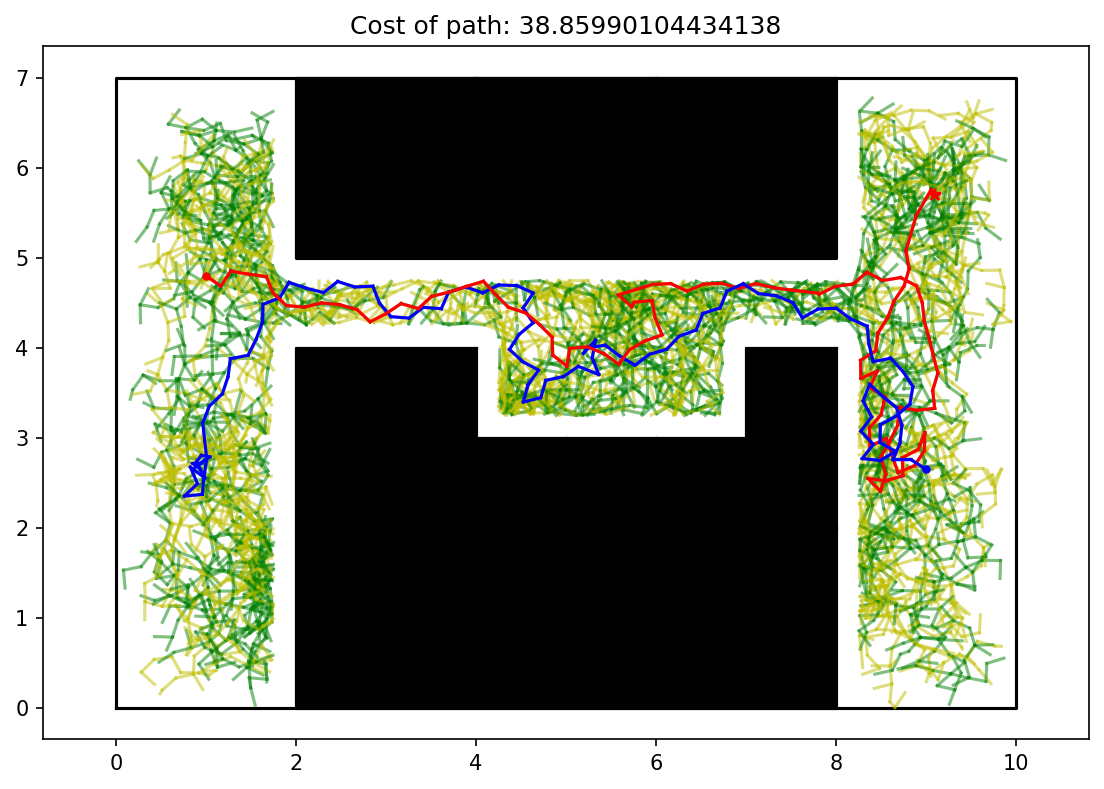

In [22]:
region_h = [0.0, 10.0]
region_w = [0.0, 7.0]

env_multi = [
    Point(3.0, 1.0).buffer(1.0, cap_style=3),
    Point(5.0, 1.0).buffer(1.0, cap_style=3),
    Point(7.0, 1.0).buffer(1.0, cap_style=3),
    Point(3.0, 6.0).buffer(1.0, cap_style=3),
    Point(5.0, 6.0).buffer(1.0, cap_style=3),
    Point(7.0, 6.0).buffer(1.0, cap_style=3),
    Point(3.0, 3.0).buffer(1.0, cap_style=3),
    Point(4.5, 2.5).buffer(0.5, cap_style=3),
    Point(5.5, 2.5).buffer(0.5, cap_style=3),
    Point(6.5, 2.5).buffer(0.5, cap_style=3),
    Point(7.5, 2.5).buffer(0.5, cap_style=3),
    Point(7.5, 3.5).buffer(0.5, cap_style=3)
]

starts =  [[9.,2.65], [1.0,4.8]]
goals =  [[0.9, 2.7], [9.1, 5.7]]
step_size = 0.2

def run_for_iterations(num_iterations):
    links = RRT(starts, goals, env_multi, region_h, region_w,
                num_iterations, step_size)
    print(f"Path Length (Iterations: {num_iterations}): {get_goal_path_length(goals, links, step_size)}")
    path1, path2 = plot_environment_and_links(starts, goals, env_multi, links, do_plot_goal_path=True)
    return path1, path2


plt.figure(figsize=(9, 6), dpi=150)
plt.plot([0, 10, 10, 0, 0], [0, 0, 7, 7, 0], 'black')
# plot_env(starts, goals, env_multi)
iteration = 7000
path1, path2 = run_for_iterations(iteration)
print("x\h values of the trajectory 1\n")
for i in range(len(path1)):
  print(round(path1[i][0], 2), end =", ")
print("y\w values of the trajectory 1\n")
for i in range(len(path1)):
  print(round(path1[i][1], 2), end =", ")
print("x\h values of the trajectory 2\n")
for i in range(len(path2)):
  print(round(path2[i][0], 2), end =", ")
print("y\w values of the trajectory 2\n")
for i in range(len(path2)):
  print(round(path2[i][1], 2), end =", ")
# plot_env(starts, goals, env_multi)

### Convert RRT-trajectoryies into IRL expert trajectories

In [ ]:
def get_actions(path):
  actions = []
  for i in range(len(path))-1:
    action_h = path[i+1][0] - path[i][0]
    action_w = path[i+1][1] - path[i][1]
    actions.append([action_h, action_w])
  return actions

def generate_expert_trajectories(env, paths, actions):
  max_len = np.max(actions[0], actions[1])
  states1 = []
  oriens1 = []
  actions1 = []
  states2 = []
  oriens2 = []
  actions2 = []
  env.set_goal(0, paths[0][-1])
  env.set_goal(1, paths[1][-1])
  for i in range(max_len):
    for r in range(2):
      if i > len(actions[r]):
        continue
      # pos = paths[r][i]
      env.set_start(r, paths[r][i]):
    # self.agents[robotId] = pos
      images, orien, _, _, _ = env.step(r, actions[r][i])
      if r ==0:
        states1.append(images)
        oriens1.append(orien)
        actions1.append(actions[r][i])
      else:
        states2.append(images)
        oriens2.append(orien)
        actions2.append(actions[r][i])

  return states1, oriens1, actions1, states2, oriens2, actions2

## Main

In [ ]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if len(gpus) > 0:
#     print(f'GPUs {gpus}')
#     try: tf.config.experimental.set_memory_growth(gpus[0], True)
#     except RuntimeError: pass


if __name__ == "__main__":
    env_name = '2 Agents - Continuous Action Space'
    n_agents = 2
    obs_num = 4
    n_actions = 2
    batch_size = 64
    n_epochs = 5
    input_dims = [4,100,100]
    pose_shape = 3
    n_games = 200
    start_time = time.time()
    agent = PPO_Agent(n_actions=n_actions, input_dims=input_dims, pose_shape=pose_shape, \
                      batch_size=batch_size, n_epochs=n_epochs, n_games=n_games)
    env = create_environment(obs_num, agent_num=n_agents, map_width=7.0, map_height=10.0, agent_size=0.5)
    agent.run_batch(env) # train as PPO
    # agent.run_multiprocesses(num_worker = 30)  # train PPO multiprocessed (fastest)
    # agent.test()
    # m, s = divmod(int(time.time() - start_time), 60)
    # h, m = divmod(m, 60)
    # print ("Total training time: %d:%02d:%02d" % (h, m, s))

Reset and run episode 0
Reset and run episode 1
Reset and run episode 2
Reset and run episode 3
training the actor and critic
training the actor and critic
Reset and run episode 4
Reset and run episode 5
Reset and run episode 6
training the actor and critic
training the actor and critic
Reset and run episode 7
Reset and run episode 8
Reset and run episode 9
training the actor and critic
training the actor and critic
Reset and run episode 10
Reset and run episode 11
Reset and run episode 12
training the actor and critic
training the actor and critic
Reset and run episode 13
Reset and run episode 14
Reset and run episode 15
training the actor and critic
training the actor and critic
Reset and run episode 16
Reset and run episode 17
Reset and run episode 18
Reset and run episode 19
training the actor and critic
training the actor and critic
Reset and run episode 20
Reset and run episode 21
Reset and run episode 22
training the actor and critic
training the actor and critic
Reset and run e

In [ ]:
!tensorboard --logdir runs